In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings as wr
from collections import ChainMap
from scipy.signal import hilbert, get_window
from scipy.fft import rfft, rfftfreq
wr.filterwarnings('ignore')

## Importing the dataset

In [31]:
df1 = pd.read_csv('Turbine_1.csv',low_memory=False)
df2 = pd.read_csv('Turbine_2.csv',low_memory=False)

In [32]:
# Data related information
fs:float = 62.5 # Data is collected at 62.5Hz frequency


## Function to extract time and spectral feature

In [33]:
# Function to extract time features from each window
def time_features(x: np.ndarray) -> dict:
    x = x.astype(float, copy=False)
    mean = x.mean()  # may indicate sensor bias or mounting issues
    rms  = np.sqrt((x**2).mean())  # overall vibration energy level
    std  = x.std(ddof=1) if len(x) > 1 else 0.0  # overall vibration energy level
    p2p  = x.max() - x.min()  # High P2P means strong impacts or shocks
    skew = (((x-mean)/(std+1e-12))**3).mean() if std > 0 else 0.0  #distribution
    kurt = (((x-mean)/(std+1e-12))**4).mean() if std > 0 else 3.0  # peakedness
    crest   = np.abs(x).max() / (rms + 1e-12)  # measures general impulsiveness
    impulse = np.abs(x).max() / (np.abs(x).mean() + 1e-12)  # more sensitive to occasional impulses
    shape   = rms / (np.abs(x).mean() + 1e-12)  # unbalance and misalignment defects
    absx = np.abs(x)
    max_abs = absx.max()
    clearance = max_abs / ( (np.mean(np.sqrt(absx)) + 1e-12) ** 2 )  # pick up local defects (like cracks, spalls, or pitting in bearings)
    margin    = max_abs / ( (np.mean(np.sqrt(np.sqrt(absx))) + 1e-12) ** 4 )  # more sensitive to weak impulsive activity than the clearance factor

    return dict(
        mean=float(mean), rms=float(rms), std=float(std), p2p=float(p2p),
        skew=float(skew), kurtosis=float(kurt),
        crest_factor=float(crest), impulse_factor=float(impulse),
        shape_factor=float(shape),
        clearance_factor=float(clearance), margin_factor=float(margin)
    )


In [34]:
def spectral_features(x: np.ndarray, fs: float) -> dict:
    X = rfft(x)
    freqs = rfftfreq(len(x), 1/fs)
    mag = np.abs(X) / (len(x)/2)

    # dominant (ignore DC)
    idx = np.argmax(mag[1:]) + 1 if len(mag) > 1 else 0
    dom_f = float(freqs[idx]) if idx is not None else 0.0
    dom_a = float(mag[idx]) if idx is not None else 0.0

    # looseness
    env = np.abs(hilbert(x))
    env_kurt = (((env - env.mean())/(env.std(ddof=1)+1e-12))**4).mean() if len(env) > 1 else 0.0 

    return dict(dominant_freq=dom_f, dominant_amp=dom_a, envelope_kurtosis=float(env_kurt))

## Channels available in the dataset

In [35]:
col = []
axes = ["edge", "span", "flap"]
blade = [1,2,3]
for i in blade:
    for loc in ["root", "tip"]:
        for ax in axes:
            name = f"B{i}_{loc}_{ax}"
            col.append(name)

In [36]:
data_T1 = pd.DataFrame()

for i in col:
    f1 = time_features(np.array(df1[i]))  # returns a dict of features
    f2 = spectral_features(np.array(df1[i]),fs=62.5)
    feats = f1|f2
    df_feat = pd.DataFrame.from_dict(feats, orient='index', columns=[i])
    data_T1 = pd.concat([data_T1, df_feat], axis=1)

data_T1

,B1_root_edge,B1_root_span,B1_root_flap,B1_tip_edge,B1_tip_span,B1_tip_flap,B2_root_edge,B2_root_span,B2_root_flap,B2_tip_edge,B2_tip_span,B2_tip_flap,B3_root_edge,B3_root_span,B3_root_flap,B3_tip_edge,B3_tip_span,B3_tip_flap
mean,-0.167230,-0.550681,-0.097889,-0.212611,-3.458833,-0.142162,-0.161190,-0.560249,-0.104171,-0.197018,-3.876915,-0.172093,-0.178233,-0.545754,-0.069171,-0.273594,-3.936900,-0.185567
rms,0.632524,0.900222,0.389383,0.653400,3.531001,0.362096,0.605751,0.901863,0.427735,0.642976,3.943529,0.387360,0.617830,0.884053,0.381975,0.685498,4.004232,0.385828
std,0.610026,0.712154,0.376883,0.617850,0.710250,0.333026,0.583919,0.706747,0.414861,0.612056,0.721780,0.347038,0.591571,0.695496,0.375665,0.628541,0.731238,0.338277
p2p,1.957250,2.202563,2.046188,2.082500,2.682500,1.554000,1.878125,2.166250,1.445688,2.114250,2.764750,1.682000,1.854563,2.146938,1.318000,2.214750,2.796000,1.691500
skew,-0.000228,-0.003421,0.020845,0.001654,-0.005205,0.004194,-0.001929,0.001866,0.026491,0.000972,-0.003871,0.008971,0.002524,0.003212,0.017206,0.005736,-0.002531,-0.009541
kurtosis,1.508992,1.508585,1.556081,1.526087,1.752743,1.672756,1.510287,1.508814,1.544787,1.530323,1.804818,1.677844,1.509001,1.508862,1.550882,1.531645,1.801842,1.703681
crest_factor,1.756850,1.858917,3.386288,1.907330,1.365689,2.416484,1.736067,1.828576,1.786593,1.931254,1.340170,2.622882,1.763632,1.837701,1.791676,2.004383,1.340769,2.638482
impulse_factor,1.988162,2.265010,3.835057,2.181832,1.394184,2.821778,1.965305,2.231169,2.019314,2.203139,1.363197,3.089676,2.001628,2.239339,2.013232,2.321697,1.363700,3.142078
shape_factor,1.131663,1.218457,1.132526,1.143920,1.020865,1.167721,1.132044,1.220167,1.130260,1.140781,1.017182,1.177970,1.134946,1.218554,1.123659,1.158310,1.017103,1.190866
clearance_factor,2.197809,2.648404,4.241533,2.429095,1.409351,3.179568,2.172323,2.613336,2.231265,2.448245,1.375325,3.504930,2.215682,2.619048,2.215009,2.602073,1.375775,3.591804


In [37]:
data_T2 = pd.DataFrame()

for i in col:
    f1 = time_features(np.array(df2[i]))  # returns a dict of features
    f2 = spectral_features(np.array(df2[i]),fs=62.5)
    feats = f1|f2
    df_feat = pd.DataFrame.from_dict(feats, orient='index', columns=[i])
    data_T2 = pd.concat([data_T2, df_feat], axis=1)

data_T2

,B1_root_edge,B1_root_span,B1_root_flap,B1_tip_edge,B1_tip_span,B1_tip_flap,B2_root_edge,B2_root_span,B2_root_flap,B2_tip_edge,B2_tip_span,B2_tip_flap,B3_root_edge,B3_root_span,B3_root_flap,B3_tip_edge,B3_tip_span,B3_tip_flap
mean,-0.167108,-0.490719,-0.094327,-0.197724,-3.337629,-0.187434,-0.120521,-0.696548,-0.130794,-0.238209,-3.530645,-0.207958,-0.158216,-0.514366,-0.121214,-0.210986,-3.539043,-0.150299
rms,0.644883,0.857367,0.354943,0.671041,3.409311,0.372681,0.676842,0.996266,0.301145,0.715923,3.599487,0.336417,0.649201,0.873738,0.373200,0.679727,3.608023,0.355637
std,0.622864,0.703054,0.342184,0.641258,0.695450,0.322122,0.666034,0.712306,0.271263,0.675140,0.700616,0.264446,0.629635,0.706300,0.352971,0.646162,0.702149,0.322321
p2p,2.119938,2.141188,1.168313,2.317750,2.564250,1.771250,2.253938,2.196000,1.070188,2.434500,2.596750,1.665000,2.137375,2.156063,1.211063,2.373250,2.548750,1.798500
skew,-0.011272,0.012447,0.031684,-0.017788,0.019271,-0.026454,-0.004464,0.010029,0.013134,-0.011369,0.015355,-0.060432,-0.007833,0.006267,0.033732,-0.017368,0.011297,-0.032257
kurtosis,1.514028,1.505195,1.529687,1.541035,1.559523,1.872525,1.513512,1.504518,1.569548,1.541256,1.564367,2.074738,1.514000,1.505441,1.529864,1.542553,1.566763,1.903616
crest_factor,1.895014,1.824701,1.857871,2.080351,1.346166,2.985123,1.781251,1.791817,2.203254,1.979962,1.338108,3.249684,1.887224,1.827922,1.914358,1.991240,1.327805,2.921514
impulse_factor,2.146818,2.193040,2.098146,2.374333,1.375078,3.583449,1.997899,2.222032,2.569278,2.272581,1.364198,4.011875,2.133280,2.208661,2.178774,2.278641,1.353685,3.462791
shape_factor,1.132877,1.201863,1.129328,1.141313,1.021477,1.200436,1.121627,1.240100,1.166129,1.147790,1.019498,1.234543,1.130380,1.208291,1.138123,1.144333,1.019491,1.185273
clearance_factor,2.375498,2.529100,2.315237,2.639009,1.390493,4.116502,2.197376,2.667444,2.890551,2.534451,1.378022,4.748632,2.358049,2.559873,2.414442,2.537205,1.367392,3.929007


## Function to create Sliding Window

In [38]:
# Function to create a sliding window with 50 % overlap

def sliding_windows(x: np.ndarray, win: int, hop: int) -> np.ndarray:
    if len(x) < win:
        return np.empty((0, win))
    n = 1 + (len(x) - win) // hop
    strides = (x.strides[0]*hop, x.strides[0])
    return np.lib.stride_tricks.as_strided(x, shape=(n, win), strides=strides).copy()

## Extracting Time and Spectral Features for each Sliding Window

In [39]:
# ---- main feature extraction for 20s windows with 50% overlap ----
def extract_20s_features(df: pd.DataFrame, fs: float, channels=None) -> pd.DataFrame:
    """
    Compute time + spectral features for all 20s windows (50% overlap)
    for each channel in `channels` (default: your `col` list).
    """
    if channels is None:
        channels = col
    
    win_sec = 20.0
    win = int(win_sec * fs)          # samples per window
    hop = win // 2                   # 50% overlap

    # use sample index as "time" if df has no time index
    sample_indices = np.arange(len(df))

    all_rows = []

    for ch in channels:
        x = df[ch].to_numpy(dtype=float)
        win_array = sliding_windows(x, win, hop)

        # window start sample indices
        n_win = win_array.shape[0]
        starts = sample_indices[0 : 0 + n_win * hop : hop]

        for w_idx, (w_data, start) in enumerate(zip(win_array, starts)):
            tf = time_features(w_data)
            sf = spectral_features(w_data, fs)

            row = {
                "channel": ch,
                "window_index": w_idx,
                "start_sample": int(start),
                "end_sample": int(start + win),
                "start_time_s": float(start / fs),
                "end_time_s": float((start + win) / fs),
            }
            # merge feature dicts (prefix to avoid collisions if needed)
            for k, v in tf.items():
                row[f"time_{k}"] = v
            for k, v in sf.items():
                row[f"spec_{k}"] = v

            all_rows.append(row)

    feat_df = pd.DataFrame(all_rows)
    return feat_df



## Plot to compare the channels in Time Domain

In [40]:
def plot_feature_compare(feat1: pd.DataFrame,
                         feat2: pd.DataFrame,
                         feature: str = "time_rms",
                         channels=None,
                         use_time_axis: bool = False):
    """
    Compare one feature between feat1 and feat2 for each channel.

    Parameters
    ----------
    feat1, feat2 : DataFrames returned by extract_20s_features
    feature : column name to compare (e.g. 'time_rms', 'time_mean', 'spec_dominant_freq', ...)
    channels : list of channel names. If None, inferred from feat1['channel'].
    use_time_axis : if True, x-axis is start_time_s; otherwise window_index.
    """
    if channels is None:
        channels = sorted(feat1["channel"].unique())

    n_ch = len(channels)
    ncols = 3
    nrows = int(np.ceil(n_ch / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), squeeze=False)
    fig.suptitle(f"Comparison of {feature} for df1 vs df2", fontsize=14)

    for idx, ch in enumerate(channels):
        r, c = divmod(idx, ncols)
        ax = axes[r][c]

        f1_ch = feat1[feat1["channel"] == ch].sort_values("window_index")
        f2_ch = feat2[feat2["channel"] == ch].sort_values("window_index")

        if use_time_axis:
            x1 = f1_ch["start_time_s"].to_numpy()
            x2 = f2_ch["start_time_s"].to_numpy()
            x_label = "Time (s)"
        else:
            x1 = f1_ch["window_index"].to_numpy()
            x2 = f2_ch["window_index"].to_numpy()
            x_label = "Window index"

        if feature not in f1_ch.columns or feature not in f2_ch.columns:
            ax.text(0.5, 0.5, f"{feature} not found", ha="center", va="center")
            ax.set_axis_off()
            continue

        y1 = f1_ch[feature].to_numpy()
        y2 = f2_ch[feature].to_numpy()

        ax.plot(x1, y1, marker="o", linestyle="-", label="Turbine 1")
        ax.plot(x2, y2, marker="x", linestyle="--", label="Turbine 2")

        ax.set_title(ch)
        ax.set_xlabel(x_label)
        ax.set_ylabel(feature)
        ax.grid(True)
        ax.legend(fontsize=8)

    # Hide any unused subplots
    for idx in range(n_ch, nrows*ncols):
        r, c = divmod(idx, ncols)
        axes[r][c].set_axis_off()

    plt.tight_layout()
    plt.show()


In [41]:

feat1 = extract_20s_features(df1, fs)
feat2 = extract_20s_features(df2, fs)

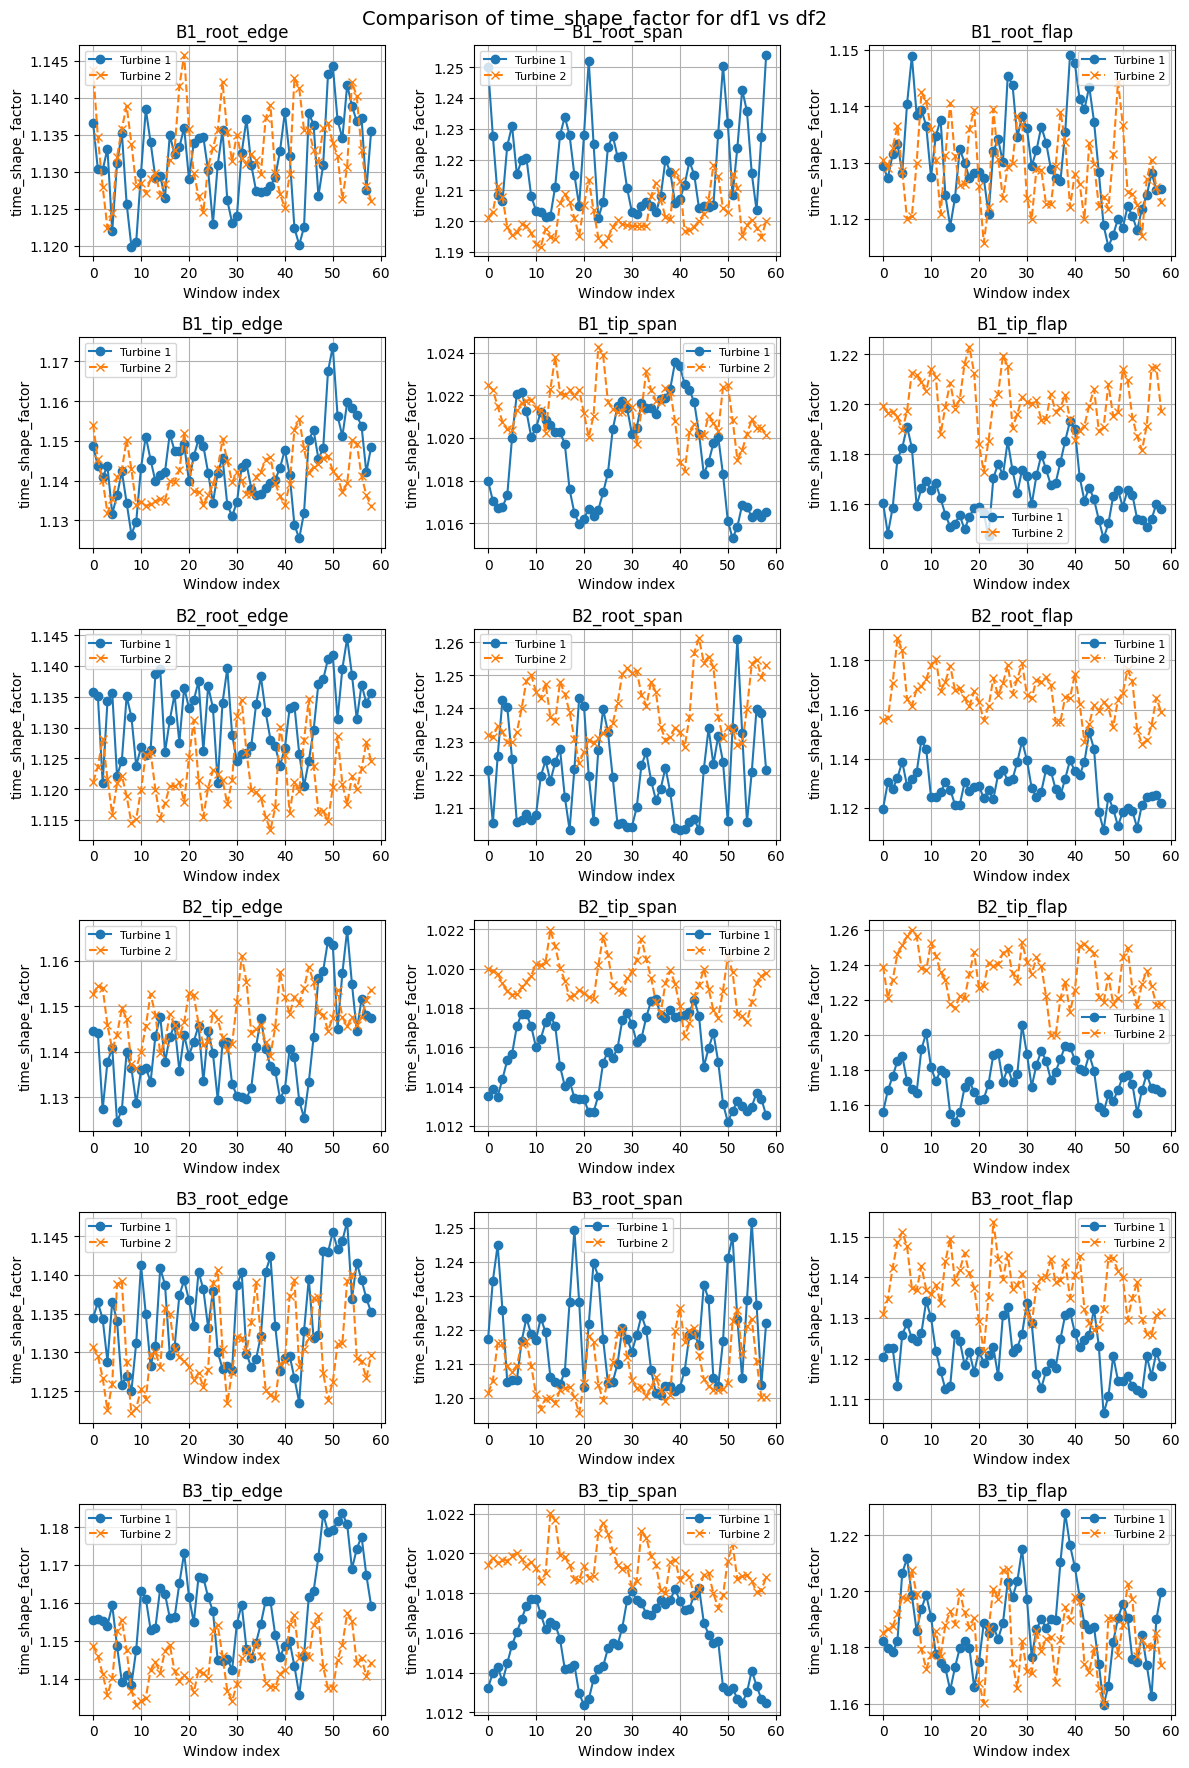

In [42]:
plot_feature_compare(feat1, feat2, feature="time_shape_factor", channels=col, use_time_axis=False)
